In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:


from pathlib import Path
import numpy as np 
import pandas as pd 
import cv2
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split

import os


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:

PATH = Path('./')
#list(PATH.iterdir())

In [4]:

masks_csv = pd.read_csv("train_masks.csv")
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [5]:
meta_csv = pd.read_csv("metadata.csv")
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [55]:
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
CAR_ID='00087a6bd4dc'
TRAIN_DN='train'

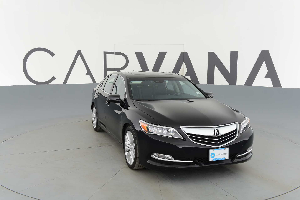

In [8]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_16.jpg').resize((512,512))

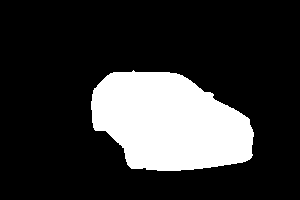

In [9]:
Image.open("train_masks/00087a6bd4dc_16_mask.gif").resize((512,512))

In [10]:

def display_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [11]:
def open_image(fn):

    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [31]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

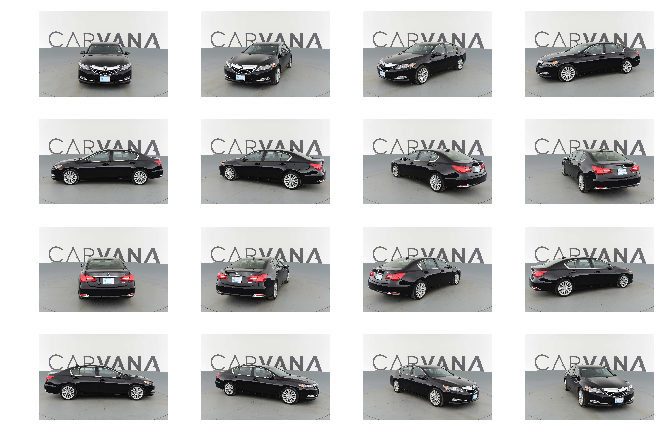

In [32]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): display_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

<b> converting gif into png and resizing the images</b>

In [33]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [34]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')


In [37]:
from concurrent.futures import ThreadPoolExecutor

In [38]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [47]:
(PATH/'train_masks-512').mkdir(exist_ok=True)

In [49]:

def resize_mask(fn):
    Image.open(fn).resize((512,512)).save((fn.parent.parent)/'train_masks-512'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [50]:
(PATH/'train-512').mkdir(exist_ok=True)

In [51]:
def resize_img(fn):
    Image.open(fn).resize((512,512)).save((fn.parent.parent)/'train-512'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [52]:
TRAIN_DN = 'train-512'
MASKS_DN = 'train_masks-512'

In [53]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

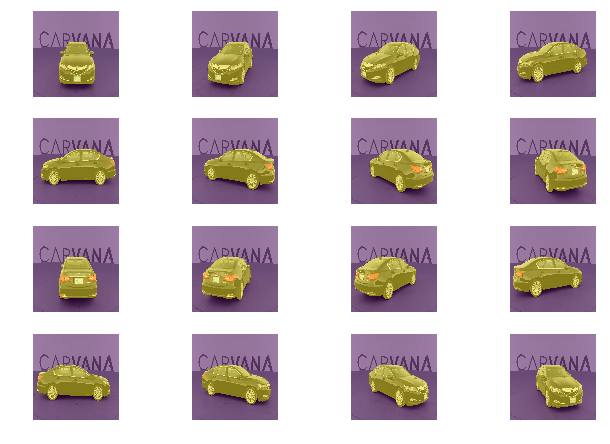

In [66]:

fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = display_img(ims[i], ax=ax)
    display_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

### TRAINING

In [32]:
from model import get_unet512
from generator import randomHueSaturationValue,randomShiftScaleRotate,randomHorizontalFlip,callbacks
from keras.optimizers import RMSprop,Adam
import keras.backend as K

from keras.losses import binary_crossentropy

In [33]:
#Loss function and eval metrics
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [34]:

epochs = 50
model = get_unet512((512,512,3),num_class=1)
input_size = 512
df_train = pd.read_csv('train_masks.csv')
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

Training on 4070 samples
Validating on 1018 samples


In [35]:
ids_valid_split.reset_index(drop=True,inplace=True)

In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 512, 512, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 512, 512, 16) 64          conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 512, 512, 16) 0           batch_normalization_56[0][0]     
__________________________________________________________________________________________________
max_poolin

In [40]:
batch_size = 8

In [41]:

def train_generator():
    while True:
        for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            for id in ids_train_batch.values:
                img = cv2.imread('./train-512/{}.jpg'.format(id))
                #img = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread('./train_masks-512/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
                #mask = cv2.resize(mask, (input_size, input_size))

                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                assert mask.ndim == 3
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch


def valid_generator():
    while True:
        for start in range(0, len(ids_valid_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch.values:
                img = cv2.imread('./train-512/{}.jpg'.format(id))
                #img = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread('./train_masks-512/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
                #mask = cv2.resize(mask, (input_size, input_size))
                mask = np.expand_dims(mask, axis=2)
                assert mask.ndim == 3
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch


In [44]:
model.compile(optimizer=Adam(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])

model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(batch_size)),
                    epochs=10,
                    verbose=1,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(batch_size)))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/10
509/509 [==============================] - 372s 731ms/step - loss: 0.0523 - dice_coeff: 0.9672 - val_loss: 0.0437 - val_dice_coeff: 0.9734
Epoch 2/10
509/509 [==============================] - 366s 718ms/step - loss: 0.0353 - dice_coeff: 0.9787 - val_loss: 0.0323 - val_dice_coeff: 0.9811
Epoch 3/10
509/509 [==============================] - 365s 718ms/step - loss: 0.0267 - dice_coeff: 0.9844 - val_loss: 0.0252 - val_dice_coeff: 0.9857
Epoch 4/10
509/509 [==============================] - 366s 719ms/step - loss: 0.0219 - dice_coeff: 0.9875 - val_loss: 0.0222 - val_dice_coeff: 0.9878
Epoch 5/10
509/509 [==============================] - 366s 719ms/step - loss: 0.0188 - dice_coeff: 0.9895 - val_loss: 0.0195 - val_dice_coeff: 0.9895
Epoch 6/10
509/509 [==============================] - 366s 720ms/step - loss: 0.0168 - dice_coeff: 0.9908 - val_loss: 0.0192 - val_dice_coeff: 0.9900
Epoch 7/10
509/509 [==============================] - 366s 720ms/step - loss: 0.0156 - dice_coeff: 0

In [45]:
model.save_weights('unet.h5')

#### Actual Mask

In [53]:
TRAIN_DN = 'train-512'
MASKS_DN = 'train_masks-512'
ims = [open_image(PATH/TRAIN_DN/f'{ids_valid_split[i]}.jpg') for i in range(4)]
im_masks = [open_image(PATH/MASKS_DN/f'{ids_valid_split[i]}_mask.png') for i in range(4)]

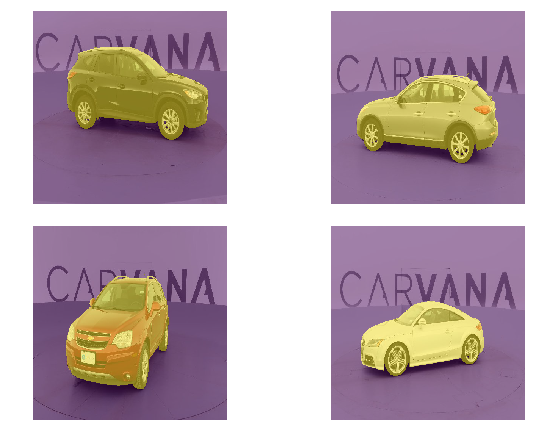

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = display_img(ims[i], ax=ax)
    display_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

#### Predicted Mask

In [66]:
test=[(cv2.imread('./train-512/{}.jpg'.format(ids_valid_split[i])))for i in range(4)]

In [69]:
test = np.array(test, np.float32) / 255.

In [70]:
pred_mask=model.predict(test)

(4, 512, 512, 3)

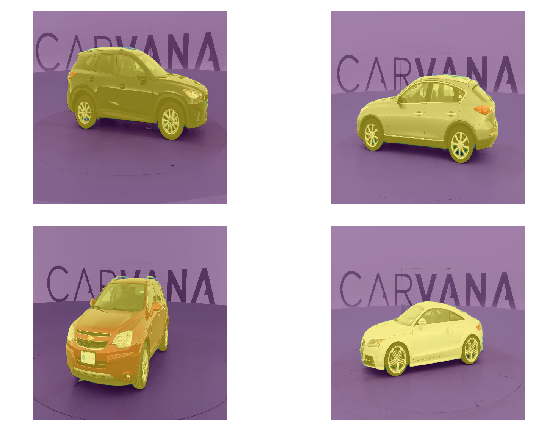

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = display_img(ims[i], ax=ax)
    display_img(pred_mask[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)